This notebook is dedicated to Classification models for a preprocessed dataset.

In [1]:
# Useful libraries
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Import some useful functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Cleaner to look at, the warnings will usually be convergence issues
import warnings
warnings.filterwarnings('ignore')


We import the preprocessed data into a pandas DataFrame and make sure we only have the features we want (no index column which was created by pd.to_csv automatically). Then we split the preprocessed data into training and test sets.

In [2]:
df = pd.read_csv('data/loan_preprocessed_all_hangyu.csv')
feature_list = ['term', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'addr_state',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'pub_rec', 'revol_bal', 'initial_list_status',
       'out_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type']

df = df.filter(feature_list)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752938 entries, 0 to 752937
Data columns (total 25 columns):
term                           752938 non-null int64
grade                          752938 non-null int64
emp_length                     752938 non-null int64
home_ownership                 752938 non-null int64
annual_inc                     752938 non-null float64
verification_status            752938 non-null int64
loan_status                    752938 non-null int64
purpose                        752938 non-null int64
addr_state                     752938 non-null int64
delinq_2yrs                    752938 non-null float64
inq_last_6mths                 752938 non-null float64
mths_since_last_delinq         752938 non-null float64
mths_since_last_record         752938 non-null float64
pub_rec                        752938 non-null float64
revol_bal                      752938 non-null float64
initial_list_status            752938 non-null int64
out_prncp                  

In [3]:
N = 200000
# Create training and test data
train_df, test_df = train_test_split(df, test_size=0.2)

# Split label and features
X_train = train_df.drop('loan_status', axis=1)
Y_train = train_df['loan_status'].ravel()

X_test = test_df.drop('loan_status', axis=1)
Y_test = test_df['loan_status'].ravel()

After splitting the data into test and training sets, we create some helper functions/classes to make the code a bit more managable. This first part will focus only on separate models (no stacking of models) and their confusion matrices/overall accuracy. 

Some things to consider in general are the effects of balanced data, the number of features, and the correlation between features.

In [4]:
# Class to extend the Sklearn classifier (just makes it easier to read different models)
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def decision_function(self,x):
        return self.clf.decision_function(x)
    
    def coef_(self, x_train, y_train):
        return self.clf.fit(x_train, y_train).coef_
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_

This sections serves to manage the parameters for each model used.

In [5]:
# Put in our parameters for models
SEED = 4444

# Logistic Regression parameters
log_params = {
    'random_state': SEED,
    'solver' : 'sag',
    'max_iter' : 100
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'random_state' : SEED,
    'tol' : 1e-5,
    'max_iter' : 1000
}

# MLP Classifer parameters
mlp_params = {
    'solver': 'lbfgs',
    'alpha': 1e-5,
    'hidden_layer_sizes': (5, 2),
    'random_state' : SEED
}

# XGBoost parameters
xgb_params = {
 'n_estimators': 2000,
 'max_depth': 4,
 'min_child_weight': 2,
 'gamma': 0.9,                        
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'objective': 'binary:logistic',
 'nthread': -1,
 'scale_pos_weight': 1
}

Now we create and train our models. Then we predict on the test set with our trained models and generate confusion matrices along with its overall accuracy as a metric of our models.

In [6]:
# Create objects that represent our models
log = SklearnHelper(clf=LogisticRegression, seed=SEED, params=log_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=LinearSVC, seed=SEED, params=svc_params)
mlp = SklearnHelper(clf=MLPClassifier, seed=SEED, params=mlp_params)
xgboost = SklearnHelper(clf=xgb.XGBClassifier, seed=SEED, params=xgb_params)

In [7]:
# Train models
log.train(X_train[0:N], Y_train[0:N])
print('Logistic Regression training done')

gb.train(X_train[0:N], Y_train[0:N])
print('Gradient-Boost training done')

svc.train(X_train[0:N], Y_train[0:N])
print('SVC training done')

xgboost.train(X_train[0:N], Y_train[0:N])
print('XGBoost training done')

#mlp.train(X_train[0:N], Y_train[0:N])
#print('MLP training done')

Logistic Regression training done
Gradient-Boost training done
SVC training done
XGBoost training done


In [8]:
# Predict on test set for accuracy metric

log_predictions = log.predict(X_test)
gb_predictions = gb.predict(X_test)
svc_predictions = svc.predict(X_test)
xgboost_predictions = xgboost.predict(X_test)
#mlp_predictions = mlp.predict(X_test)

In [9]:
# This function just computes the confusion matrix and accuracy, then displays both.
def accuracy_metric(truth, predictions, model_name):
    confusion = pd.crosstab(truth, predictions, rownames = ['Truth'], colnames = ['Prediction'], margins=True)
    print('\n------------------------------\n')
    print(model_name + ' confusion matrix: \n')
    print(confusion)
    print('\nAccuracy: ' + str((confusion[0][0] + confusion[1][1]) / len(truth)))

In [10]:
# These are the accuracies and confusion matrices over all the training data 

#accuracy_metric(Y_test, log_predictions, 'Logistic Regression')
accuracy_metric(Y_test, gb_predictions, 'Gradient Boosting')
accuracy_metric(Y_test, svc_predictions, 'Linear Support Vector Classifier')
accuracy_metric(Y_test, xgboost_predictions, 'XGBoost')
#accuracy_metric(Y_test, mlp_predictions, 'Multi-Layer Perceptron Classifier')


------------------------------

Gradient Boosting confusion matrix: 

Prediction       0     1     All
Truth                           
0           139489   823  140312
1             4387  5889   10276
All         143876  6712  150588

Accuracy: 0.9654022896910777

------------------------------

Linear Support Vector Classifier confusion matrix: 

Prediction       0     1     All
Truth                           
0           140310     2  140312
1             7352  2924   10276
All         147662  2926  150588

Accuracy: 0.9511647674449492

------------------------------

XGBoost confusion matrix: 

Prediction       0     1     All
Truth                           
0           139553   759  140312
1             4350  5926   10276
All         143903  6685  150588

Accuracy: 0.9660729938640529


In [11]:
# Plotting feature importance
def f_importances(coef, names, row, col, subplot_index, title):
    plt.subplot(row, col, subplot_index)
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title(title)

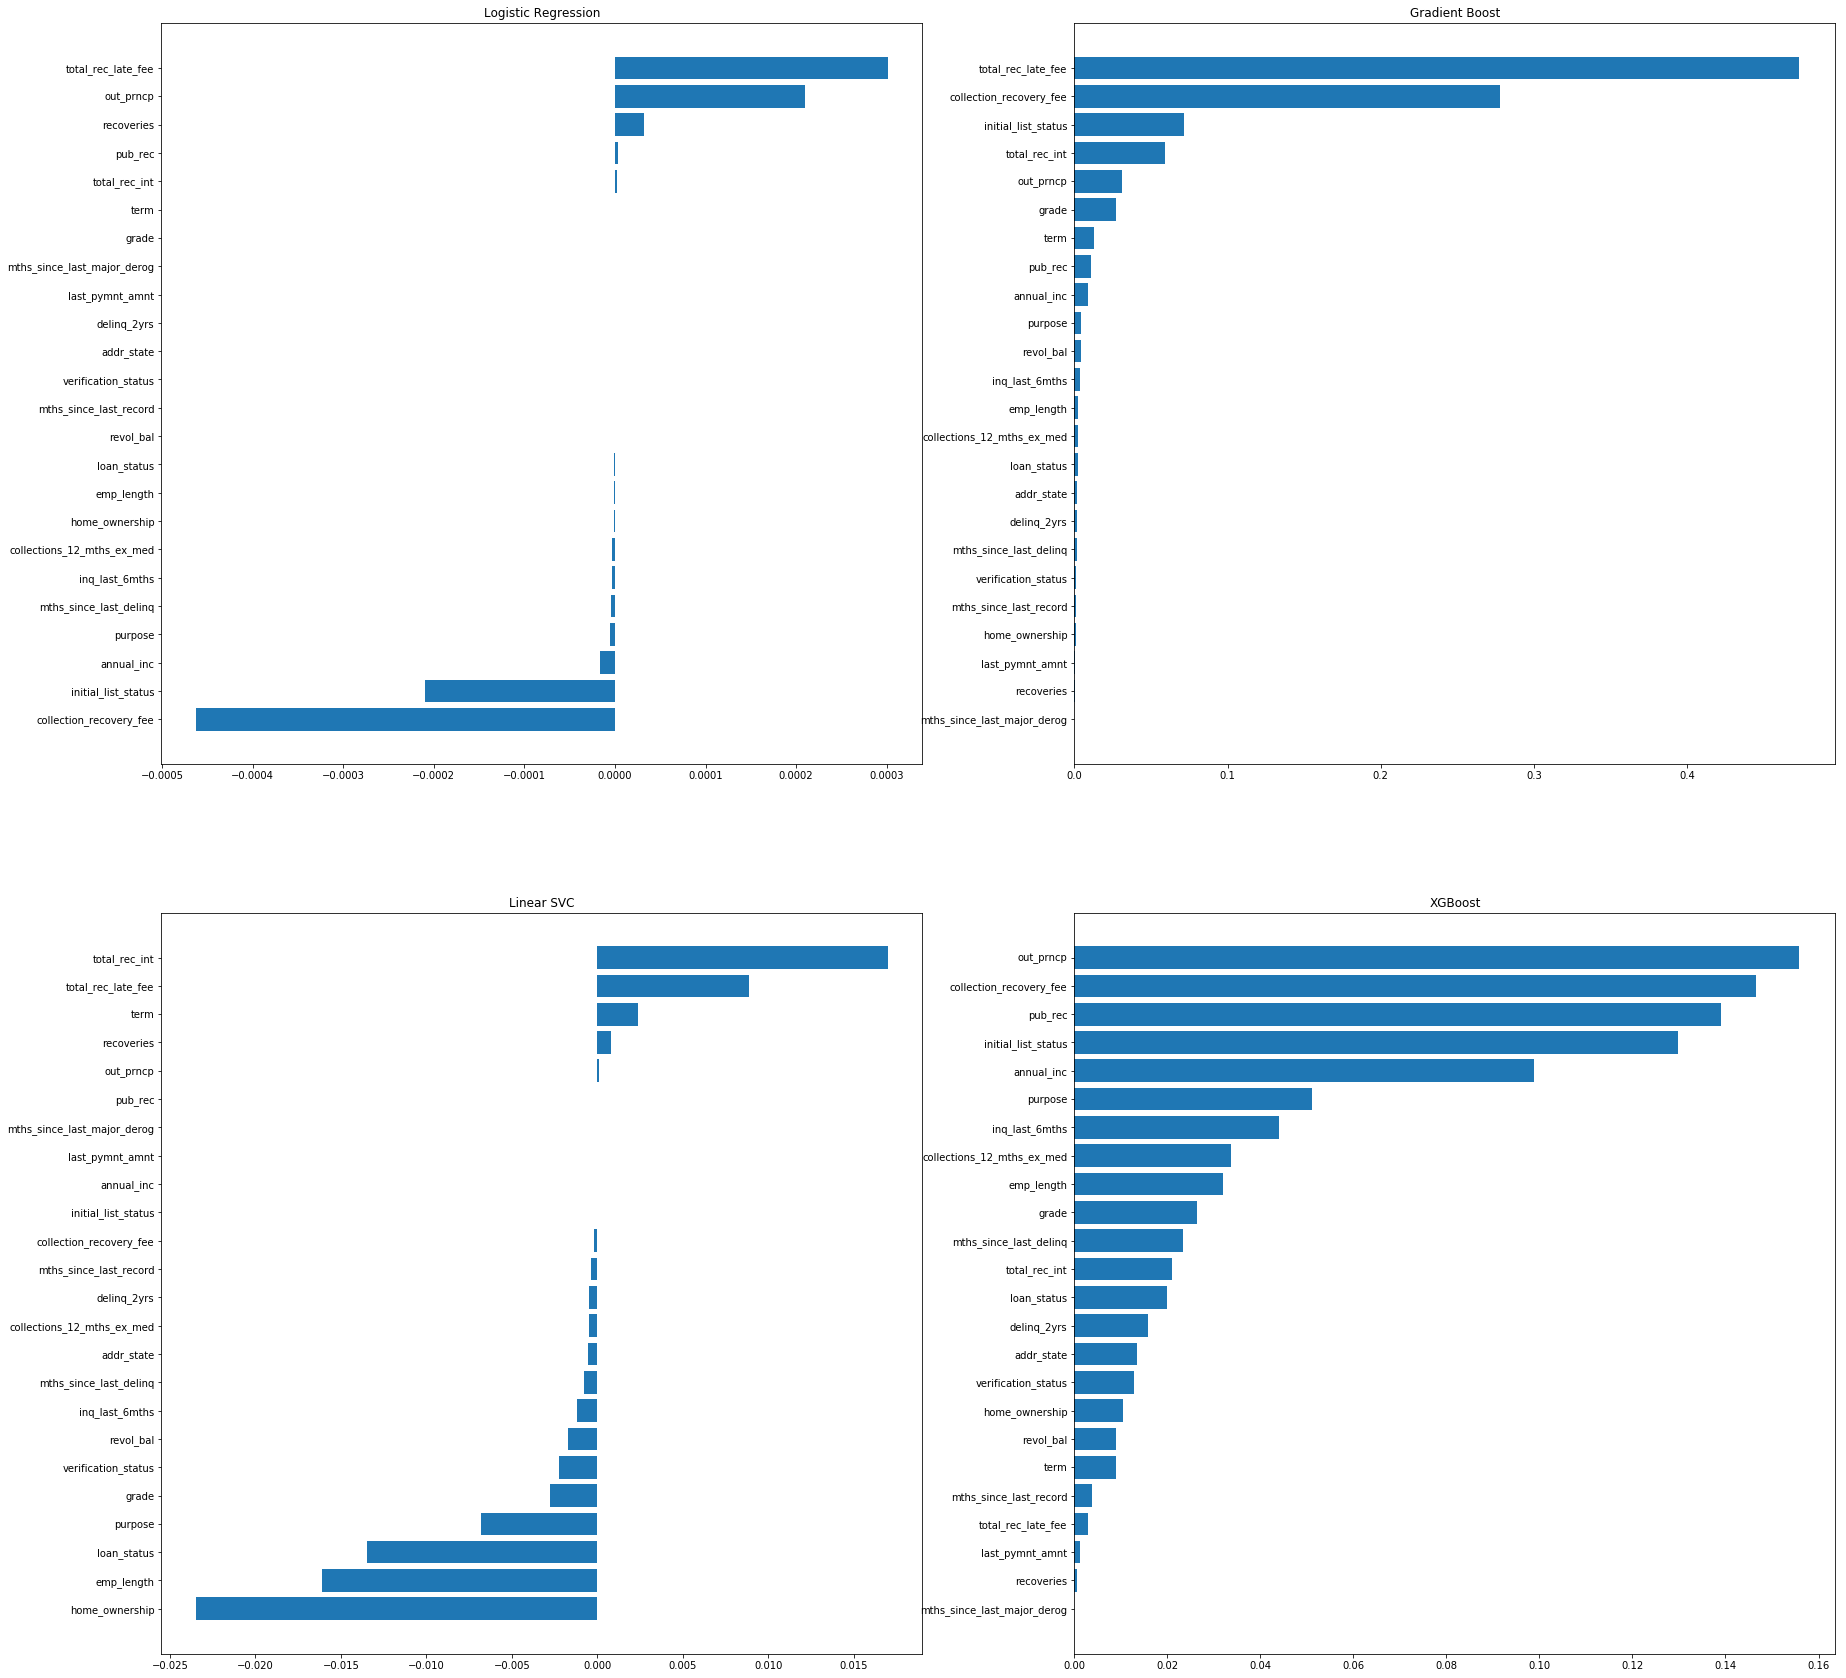

In [12]:
# Feature importance arrays (note that NN do not currently have a feature importance, current research?)
plt.figure(figsize=(30,30))
log_feature = log.fit(X_train[0:N], Y_train[0:N]).coef_
f_importances(log_feature[0], feature_list, 2, 2, 1, 'Logistic Regression')

gb_feature = gb.feature_importances(X_train[0:N], Y_train[0:N])
f_importances(gb_feature, feature_list, 2, 2, 2, 'Gradient Boost')

svc_feature = svc.fit(X_train[0:N], Y_train[0:N]).coef_
f_importances(svc_feature[0], feature_list, 2, 2, 3, 'Linear SVC')

xgboost_feature = xgboost.feature_importances(X_train[0:N], Y_train[0:N])
f_importances(xgboost_feature, feature_list, 2, 2, 4, 'XGBoost')

Here we will implement the stacked modelling approach. This approach simply uses the predictions of a number of models as the training data for another model or layer of models.

We need to use Out-of-Fold predictions in order to feed the predictions of the first layer without worrying too much about overfitting the data. At its simplest form, this is K-folding our training data and training/predicting the models on its own fold.

In [13]:
NFOLDS = 3 # set this for the number of models we want to stack in the first layer
kf = KFold(n_splits= NFOLDS, shuffle = True, random_state=SEED)

ntrain = train_df.shape[0]
ndimensions = train_df.shape[1]
ntest = test_df.shape[0]

# Out-of-fold predictions (for stacked models, pure prediction)
def get_oof(clf, x_train, y_train, x_test, choice):
    i = 0
    oof_train = np.zeros((len(x_train),))
    oof_test = np.zeros((len(x_test),))
    oof_test_skf = np.empty((NFOLDS, len(x_test)))

    for train_index, test_index in kf.split(x_train):
        x_tr = x_train.iloc[train_index,:]
        y_tr = y_train[train_index]
        x_te = x_train.iloc[test_index,:]
    
        clf.train(x_tr, y_tr)
    
        if choice == 'predict':
            oof_train[test_index] = clf.predict(x_te)
            oof_test_skf[i,:] = clf.predict(x_test)
        
        elif choice == 'decision_function':
            oof_train[test_index] = clf.decision_function(x_te)
            oof_test_skf[i,:] = clf.decision_function(x_test)
            
        i += 1

    oof_test[:] = oof_test_skf.mean(axis=0)    
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

First we will try just the raw prediction value (0,1) as the feature matrix of the 2nd layer. The 2nd layer will only consist of one model, either XGBoost or MLP.

In [14]:
# Create our OOF train and test predictions. These base predictions will be used as new features

# We will simply use three base models (Logistic Regression, GBT, Linear SVC) for layer1
# We choose these because of the scikit package's decision_function() which assigns confidence scores for these models

log_oof_train, log_oof_test = get_oof(log,X_train[0:N], Y_train[0:N], X_test, 'predict') # Logistic Regression
print("Logistic Regression training complete")

gb_oof_train, gb_oof_test = get_oof(gb,X_train[0:N], Y_train[0:N], X_test, 'predict') # Gradient Boost
print("Gradient Boosting training complete")

svc_oof_train, svc_oof_test = get_oof(svc,X_train[0:N], Y_train[0:N], X_test, 'predict') # Linear Support Vector Classifier
print("SVC training complete")

# Create new training/test feature sets for layer2 model(s)
layer1_Xtrain = np.concatenate((log_oof_train, gb_oof_train, svc_oof_train), axis=1)
layer1_Xtest = np.concatenate((log_oof_test, gb_oof_test, svc_oof_test), axis=1)

# Train layer2 (only one model at this layer) models and predict
# try MLP as layer2
mlp.train(layer1_Xtrain, Y_train[0:N])
print('MLP - Layer2 training complete')
mlp_predictions = mlp.predict(layer1_Xtest)
accuracy_metric(Y_test, mlp_predictions, 'Multi-layer Perceptron')

# try XGBoost as layer2
xgboost.train(layer1_Xtrain, Y_train[0:N])
print('\nXGBoost - Layer2 training complete')
xgboost_predictions = xgboost.predict(layer1_Xtest)
accuracy_metric(Y_test, xgboost_predictions, 'XGBoost')

Logistic Regression training complete
Gradient Boosting training complete
SVC training complete
MLP - Layer2 training complete

------------------------------

Multi-layer Perceptron confusion matrix: 

Prediction       0     1     All
Truth                           
0           139799   513  140312
1             4641  5635   10276
All         144440  6148  150588

Accuracy: 0.9657741652721332

XGBoost - Layer2 training complete

------------------------------

XGBoost confusion matrix: 

Prediction       0     1     All
Truth                           
0           139584   728  140312
1             4396  5880   10276
All         143980  6608  150588

Accuracy: 0.9659733843334131


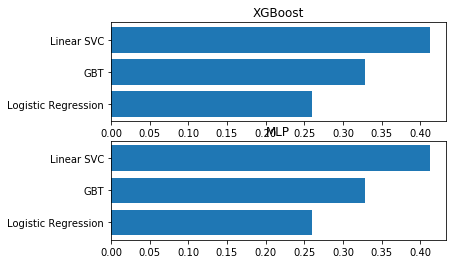

In [15]:
# Importance of models
model_list = ['Logistic Regression', 'GBT', 'Linear SVC']
xgboost_feature = xgboost.feature_importances(layer1_Xtrain, Y_train[0:N])
f_importances(xgboost_feature, model_list, 2, 1, 1, 'XGBoost')

xgboost_feature = xgboost.feature_importances(layer1_Xtrain, Y_train[0:N])
f_importances(xgboost_feature, model_list, 2, 1, 2, 'MLP')

This run is the same as before with the exception that the feature matrix will be using the confidence values given by scikit's decicions_function attritbute instead of the raw prediction.

In [16]:
# This run will be with the decision_function confidence values as the feature matrix in layer2
log_oof_train, log_oof_test = get_oof(log,X_train[0:N], Y_train[0:N], X_test, 'decision_function') # Logistic Regression
print("Logistic Regression training complete")

gb_oof_train, gb_oof_test = get_oof(gb,X_train[0:N], Y_train[0:N], X_test, 'decision_function') # Gradient Boost
print("Gradient Boosting training complete")

svc_oof_train, svc_oof_test = get_oof(svc,X_train[0:N], Y_train[0:N], X_test, 'decision_function') # Linear Support Vector Classifier
print("SVC training complete")

# Create new training/test feature sets for layer2 model(s)
layer1_Xtrain = np.concatenate((log_oof_train, gb_oof_train, svc_oof_train), axis=1)
layer1_Xtest = np.concatenate((log_oof_test, gb_oof_test, svc_oof_test), axis=1)

# Train layer2 model(s) and predict
# try MLP as layer2
mlp.train(layer1_Xtrain, Y_train[0:N])
print('MLP - Layer2 training complete')
mlp_predictions = mlp.predict(layer1_Xtest)
accuracy_metric(Y_test, mlp_predictions, 'Multi-layer Perceptron')

# try XGBoost as layer2
xgboost.train(layer1_Xtrain, Y_train[0:N])
print('\nXGBoost - Layer2 training complete')
xgboost_predictions = xgboost.predict(layer1_Xtest)
accuracy_metric(Y_test, xgboost_predictions, 'XGBoost')

Logistic Regression training complete
Gradient Boosting training complete
SVC training complete
MLP - Layer2 training complete

------------------------------

Multi-layer Perceptron confusion matrix: 

Prediction       0     1     All
Truth                           
0           139641   671  140312
1             4429  5847   10276
All         144070  6518  150588

Accuracy: 0.9661327595824368

XGBoost - Layer2 training complete

------------------------------

XGBoost confusion matrix: 

Prediction       0     1     All
Truth                           
0           139555   757  140312
1             4428  5848   10276
All         143983  6605  150588

Accuracy: 0.9655683055754775


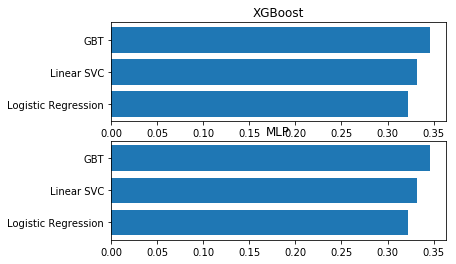

In [17]:
# Importance of models
model_list = ['Logistic Regression', 'GBT', 'Linear SVC']
xgboost_feature = xgboost.feature_importances(layer1_Xtrain, Y_train[0:N])
f_importances(xgboost_feature, model_list, 2, 1, 1, 'XGBoost')

xgboost_feature = xgboost.feature_importances(layer1_Xtrain, Y_train[0:N])
f_importances(xgboost_feature, model_list, 2, 1, 2, 'MLP')